In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage.io import imread

In [6]:
def get_images(image):
    if len(image.shape) ==3:
        x,y,z=image.shape
    else: x,y=image.shape
    
    tl =image[:x/2,:y/2]
    tr =image[:x/2,y/2+1:]
    bl =image[x/2+1:,:y/2]
    br = image[x/2+1:,y/2+1:]
    
    sel = 1024
    
    #return tr[sel:, :sel], tl[sel:, :sel], bl[sel:, :sel]
    return tr, tl, bl, br

def get_linear_slice(im, i, j, pad=15):
    return immerg2[i-pad:i+pad,j-pad:j+pad].flatten().tolist()

In [7]:
im = imread('SAV1.tif', as_grey=True)
clss = loadtxt('sav1_classifications.txt').transpose()

fl1, fl2, bf, immerg = get_images(im)

In [170]:
pad = 10
immerg2 = immerg.copy()
X = []
y = []
for counter,(i,j,c) in enumerate(clss):
    X.append(get_linear_slice(immerg, i, j, pad=pad))
    y.append(0 if c == 0 else 1)

In [171]:
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer, SigmoidLayer
from pybrain.structure import FullConnection
from pybrain.datasets            import ClassificationDataSet
from pybrain.utilities           import percentError
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules   import SoftmaxLayer
from pylab import ion, ioff, figure, draw, contourf, clf, show, hold, plot
from scipy import diag, arange, meshgrid, where
from numpy.random import multivariate_normal

In [172]:
alldata = ClassificationDataSet((pad*2)**2, 1, nb_classes=3)
immerg2 = immerg.copy()
X = []
y = []
for counter,(i,j,c) in enumerate(clss):
    alldata.addSample(immerg2[i-pad:i+pad,j-pad:j+pad].flatten().tolist(), [c-1])

In [173]:
tstdata, trndata = alldata.splitWithProportion( 0.25 )

In [174]:
trndata._convertToOneOfMany( )
tstdata._convertToOneOfMany( )

In [175]:
print "Number of training patterns: ", len(trndata)
print "Input and output dimensions: ", trndata.indim, trndata.outdim
print "First sample (input, target, class):"
#print trndata['input'][0], trndata['target'][0], trndata['class'][0]

Number of training patterns:  738
Input and output dimensions:  400 3
First sample (input, target, class):


In [183]:
fnn = buildNetwork( trndata.indim, 100, 50, 25, 5, trndata.outdim, outclass=SigmoidLayer )

In [184]:
trainer = BackpropTrainer( fnn, dataset=trndata, momentum=0.1, verbose=True, weightdecay=0.01)

In [185]:
trainer.trainUntilConvergence(maxEpochs=100)

Total error: 0.123320222791
Total error: 0.107288929292
Total error: 0.104555148146
Total error: 0.103492694933
Total error: 0.103019097883
Total error: 0.102812739557
Total error: 0.102660663301
Total error: 0.102579481537
Total error: 0.102517606171
Total error: 0.102526485143
Total error: 0.102495306003
Total error: 0.102548164932
Total error: 0.102615650733
Total error: 0.102681758224
Total error: 0.102823678736
Total error: 0.102939886301
Total error: 0.103008216466
Total error: 0.103075035204
Total error: 0.103172986701
Total error: 0.103232017327
Total error: 0.10332432031
Total error: 0.103314597255
Total error: 0.103410099678
train-errors: [  0.123320  0.107289  0.104555  0.103493  0.103019  0.102813  0.102661  0.102579  0.102518  0.102526  0.102495  0.102548  0.102616  0.102682  0.102824  0.102940  0.103008  0.103075  0.103173  0.103232  0.103324  0.103315  0.103410  0.102374]
valid-errors: [  0.156287  0.106979  0.103005  0.101768  0.101312  0.101205  0.101137  0.101134  0.1

([0.12332022279081195,
  0.1072889292923392,
  0.10455514814591516,
  0.10349269493257439,
  0.10301909788304896,
  0.10281273955671397,
  0.10266066330129363,
  0.10257948153665659,
  0.10251760617094033,
  0.10252648514342945,
  0.10249530600275206,
  0.10254816493166995,
  0.10261565073339454,
  0.10268175822361107,
  0.10282367873637893,
  0.10293988630059935,
  0.1030082164656107,
  0.10307503520436595,
  0.1031729867006539,
  0.10323201732676747,
  0.10332432031044333,
  0.10331459725511374,
  0.10341009967846539,
  0.10237376355537423],
 [0.15628749847036552,
  0.10697903982291845,
  0.10300457785580665,
  0.10176773502142972,
  0.10131238826628688,
  0.10120525692631992,
  0.10113650661262413,
  0.10113383948021508,
  0.10108422583915269,
  0.10105831931738463,
  0.10099285802859255,
  0.10103743751606933,
  0.10109923449040124,
  0.10118431208895015,
  0.10133022181536028,
  0.1014021386352587,
  0.10139703880596404,
  0.101469342701967,
  0.10157008006883249,
  0.101636997303

In [186]:
"epoch: %4d" % trainer.totalepochs, \
          "  train error: %5.2f%%" % trnresult, \
          "  test error: %5.2f%%" % tstresult

('epoch:   23', '  train error: 17.07%', '  test error: 17.89%')

In [187]:
predictions = zeros(immerg.shape)

In [188]:
selec = 800, 950
for i in range(selec[0], selec[1]):
    for j in range(selec[0], selec[1]):
        inp = get_linear_slice(immerg, i, j, pad=pad)
        predictions[i,j] = argmax(fnn.activate(inp))+1

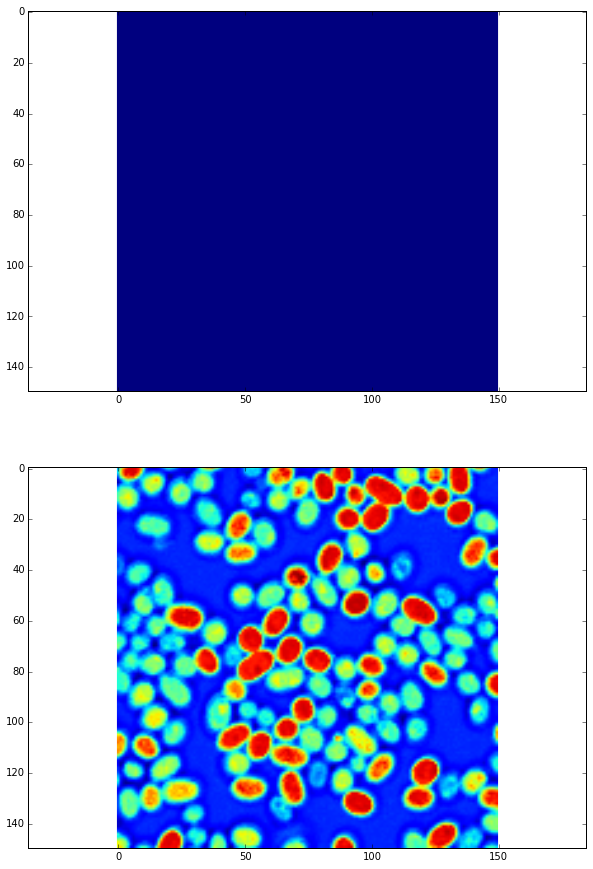

In [189]:
figure(1, figsize=(10, 15))
clf()
ax1=subplot(211)
imshow(predictions[selec[0]:selec[1], selec[0]:selec[1]])
subplot(212, sharex=ax1, sharey=ax1)
imshow(immerg[selec[0]:selec[1], selec[0]:selec[1]])

In [126]:
clss[:, 1].max()

946.0

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler